# Using keras and plaidml

The ONLY reason I am using plaidml on MAC is that no other GPU accelerated keras backend is avaliable

The following python code checks the version of keras and if you are using plaidml

The expected output is: `keras_version: 2.2.4 backend: plaidml.keras.backend`

If not, go to plaidml page at: <a href="https://github.com/plaidml/plaidml">https://github.com/plaidml/plaidml</a> and follow the steps to install and setup plaidml.

In [109]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
import numpy as np

print('keras_version:', keras.__version__ , 'backend:',keras.backend.backend())

keras_version: 2.2.4 backend: plaidml.keras.backend


If the backend is NOT plaidml.keras.backend, update the `~/.keras/keras.json` file as below:
```json
{
    "epsilon": 1e-07,
    "floatx": "float32",
    "image_data_format": "channels_last",
    "backend": "plaidml.keras.backend"
}
```
If you are still having problem, then VERIFY that you are using one of the plaidml supported GPU card.

## Demo: Using CNN network to classify MNIST digits

The code below will download MNIST digit and run a short (5 epoch) training session.
Though plaidml uses image_data_format() of "channel_last", it is ALWAYS good idea to check and convert training data to fit the image data format.

In [110]:
backend_format = keras.backend.image_data_format()
print('backend image data format:', backend_format)

backend image data format: channels_last


x_train.shape: (60000, 28, 28) y_train.shape: (60000,)
x_test.shape: (10000, 28, 28) y_test.shape: (10000,)


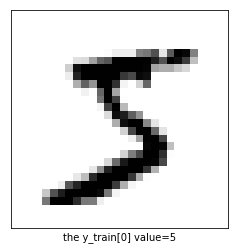

In [111]:
# get mnist data
mnist = keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

print('x_train.shape:', x_train.shape,'y_train.shape:',y_train.shape)
print('x_test.shape:', x_test.shape , 'y_test.shape:', y_test.shape)

# normalize the datq
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# convert the data from 0 to 1.0
x_train, x_test = x_train / 255, x_test / 255

x_test2 = x_test

# show 2nd digit using matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('the y_train[0] value='+str(y_train[0]))
plt.imshow(x_train[0] , cmap='gray_r')
plt.show()
plt.close()

In [112]:
# convert the shape of data depending on the image data format

if backend_format == 'channels_first':
  x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
  x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
  input_shape = (1, 28, 28)
else:
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
  x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
  input_shape = (28, 28, 1)

# get hot label output

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

print('y_test[0]', y_test[0])

y_test[0] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [113]:
# setup model and compile

model = keras.models.Sequential()
model.add( keras.layers.Conv2D(32, kernel_size=(3,3),
input_shape=input_shape , activation='relu' ))
model.add( keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu' ))
model.add( keras.layers.Dropout(0.05))
model.add( keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add( keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu' ))
model.add( keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add( keras.layers.Dropout(0.5))
model.add( keras.layers.Flatten())
model.add( keras.layers.Dense(265, activation='relu'))
model.add( keras.layers.Dropout(0.5))
model.add( keras.layers.Dense(10, activation='softmax'))

# compile to model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
dropout_19 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 5, 64)          0         
__________

In [114]:
#train the model with train data
fit_history = model.fit(x_train, y_train,
  epochs=5 ,
  batch_size=200,
  validation_data=(x_test,y_test)
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 21s 351us/step - loss: 0.2942 - acc: 0.9062 - val_loss: 0.0512 - val_acc: 0.9829
Epoch 2/5
60000/60000 [==============================] - 16s 275us/step - loss: 0.0940 - acc: 0.9708 - val_loss: 0.0353 - val_acc: 0.9881
Epoch 3/5
60000/60000 [==============================] - 17s 275us/step - loss: 0.0688 - acc: 0.9788 - val_loss: 0.0295 - val_acc: 0.9899
Epoch 4/5
60000/60000 [==============================] - 17s 275us/step - loss: 0.0584 - acc: 0.9812 - val_loss: 0.0240 - val_acc: 0.9921
Epoch 5/5
60000/60000 [==============================] - 16s 274us/step - loss: 0.0509 - acc: 0.9845 - val_loss: 0.0238 - val_acc: 0.9916


### as long as the model loss continue to decrease, you should extend the epoch to get better results

This 5 epoch run can be extended to longer value

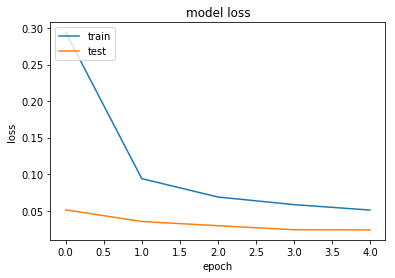

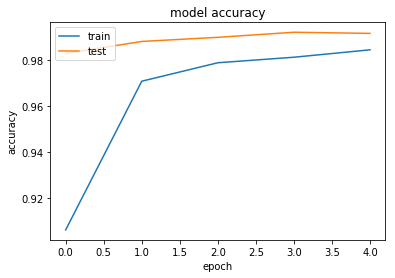

In [115]:
# show procession of training...
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(fit_history.history['acc'])
plt.plot(fit_history.history['val_acc'])
 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


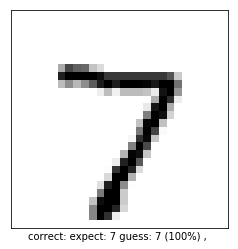

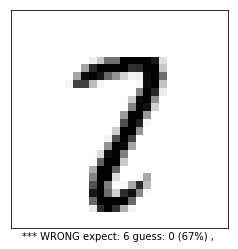

In [116]:
# predict how the x_test data performs against y_test label

predictions = model.predict(x_test)
correct_label = ''
wrong_label = ''

def find_match(isMatch): 
    global correct_label, wrong_label
    for i in range(10000):
        expected = np.argmax(y_test[i])
        guess = np.argmax(predictions[i])
        if isMatch:
            if guess == expected:
                
                correct_label ='correct: expect: ' + str(expected) + ' guess: ' + str(guess) + " ({:2.0f}%) , ".format(predictions[i][guess]*100.0)
                return i
        else:
            if guess != expected:
                
                wrong_label ='*** WRONG expect: ' + str(expected) + ' guess: ' + str(guess) + " ({:2.0f}%) , ".format(predictions[i][guess]*100.0)
                return i

        
# find matched index and missed index
correct_index = find_match(True)
wronte_index = find_match(False)

# show 0ne match and wrong

plt.figure
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel(correct_label)
plt.imshow(x_test2[correct_index] , cmap='gray_r')
plt.show()
plt.close()


plt.figure
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel(wrong_label)
plt.imshow(x_test2[wrong_index] , cmap='gray_r')
plt.show()
plt.close()

In [117]:
# 

fit_history = model.fit(x_train, y_train,
  epochs=45 ,
  batch_size=200,
  validation_data=(x_test,y_test)
)



Train on 60000 samples, validate on 10000 samples
Epoch 1/45
60000/60000 [==============================] - 16s 275us/step - loss: 0.0447 - acc: 0.9861 - val_loss: 0.0217 - val_acc: 0.9924
Epoch 2/45
60000/60000 [==============================] - 16s 274us/step - loss: 0.0393 - acc: 0.9869 - val_loss: 0.0252 - val_acc: 0.9914
Epoch 3/45
60000/60000 [==============================] - 17s 275us/step - loss: 0.0377 - acc: 0.9885 - val_loss: 0.0238 - val_acc: 0.9919
Epoch 4/45
60000/60000 [==============================] - 16s 275us/step - loss: 0.0330 - acc: 0.9897 - val_loss: 0.0182 - val_acc: 0.9942
Epoch 5/45
60000/60000 [==============================] - 17s 275us/step - loss: 0.0332 - acc: 0.9896 - val_loss: 0.0181 - val_acc: 0.9941
Epoch 6/45
60000/60000 [==============================] - 16s 275us/step - loss: 0.0299 - acc: 0.9906 - val_loss: 0.0161 - val_acc: 0.9944
Epoch 7/45
60000/60000 [==============================] - 17s 275us/step - loss: 0.0279 - acc: 0.9910 - val_loss: 0.

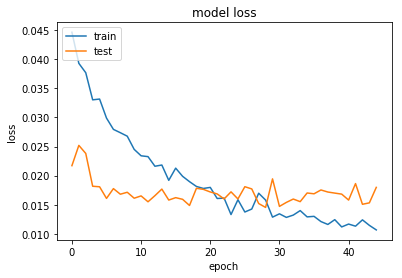

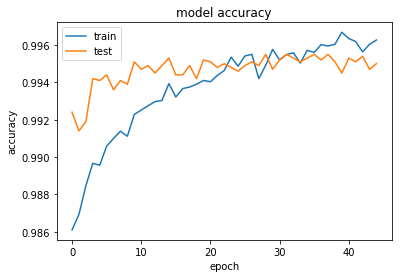

In [118]:
# show procession of training...
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(fit_history.history['acc'])
plt.plot(fit_history.history['val_acc'])
 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.close()

### over fitting
As you can see above, the loss and the accuracy on the training data improves, while the test loss and accuracy seem to reach a plateau.  That means you are trying to hard to get BIG accuracy on the training data set without getting any improvement on the test data (aka "validation" data )
